# 0. Summary of Final Solution
This notebook summarizes my final solution, which leverages the [Fastai](https://docs.fast.ai/index.html) library for training models. The models are Efficientnet-B0 and Resnet-50.

**Contents:**  
[1. Intro to Fastai Library](#1.-Intro-to-Fastai-Library)  
[2. Final Solution](#2.-Final-Solution---Best-Training-Pipeline-for-Efficientnet-B0-and-Resnet-50)  
-- [2.1 Efficientnet-B0](#2.1-Efficientnet-B0)  
-- [2.2 Resnet-50](#2.2-Resnet-50)  
[3. Evaluation of Final Solution](#3.-Evaluation-of-Final-Solution)  
-- [3.1 Retrain Efficientnet-B0 for 8 Runs](#3.1-Retrain-Efficientnet-B0-for-8-Runs)  
-- [3.2 Retrain Resnet-50 for 8 Runs](#3.2-Retrain-Resnet-50-for-8-Runs)  
[4. Evaluation of Inference Time](#4.-Evaluation-of-Inference-Time)  
-- [4.1 CPU Inference Time of Efficientnet-B0](#4.1-CPU-Inference-Time-of-Efficientnet-B0)  
-- [4.2 CPU Inference Time of Resnet-50](#4.2-CPU-Inference-Time-of-Resnet-50)  

Section 1 is prepared for those who are not familiar with the fastai library. If you are familiar with fastai or just interested in the final solution, feel free to skip to the [2. Final Solution](#2.-Final-Solution---Best-Training-Pipeline-for-Efficientnet-B0-and-Resnet-50) section.

> Note 1: Each section can be ran independently. Just remember to always **run the first import cell**.  
> Note 2: This notebook was not ran from top to bottom because some sections take a very long time to rerun the entire notebook.

In [1]:
import numpy as np
import pandas as pd
from helper import get_car_paths
from helper import get_cars_df
from helper import get_car_data
from helper import get_effnet
import random
from torch import nn
from fastai.vision import *

In [2]:
def seed_all(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

seed_all(seed=42)

# 1. Intro to Fastai Library

This section introduces briefly the two main component in fastai to train neural nets:
- DataBunch (ImageDataBunch for computer application vision applications)
- Learner

## 1.1 Getting ImageDataBunch
To train an image classifier using fastai library, we need to create an `ImageDataBunch` object, which binds train, validation and test dataloaders together for computer vision applications. Here, we create an ImageDataBunch fastai's [data block API](https://docs.fast.ai/data_block.html).

First, two things are needed for the creation of ImageDataBunch:
- path to the folder where the train images are located 
- dataframe which contains filenames and labels of the train images.

I created helper functions `get_car_paths` and `get_cars_df` in `helper.py` for this purpose. Note that the test data is  not required for experiments, it is only used for the evaluation of the final solution.

In [3]:
# If the data does not exist yet (first run), `get_car_paths` will automatically
# download and unzip all the data into correct folders.
train_path, _ = get_car_paths()
train_df = get_cars_df('cars_train_annos.mat')

In [4]:
print(f"Path to train data: {str(train_path.resolve())}")

Path to train data: /home/zw91/Projects/ai4sea/Data/cars_train


In [5]:
train_df.head()

fname                           class_name  class
0  00001.jpg                  Audi TTS Coupe 2012     14
1  00002.jpg                  Acura TL Sedan 2012      3
2  00003.jpg           Dodge Dakota Club Cab 2007     91
3  00004.jpg     Hyundai Sonata Hybrid Sedan 2012    134
4  00005.jpg  Ford F-450 Super Duty Crew Cab 2012    106

Next, the `train_path` and `train_df` are passed to the data_block APIs in the next cell to create a ImageDataBunch.

`get_transforms()` is a convinient function to get a list of fastai's standard transforms for the train and validation set. Extra transforms from [docs](https://docs.fast.ai/vision.transform.html) can also be passed to the function, e.g. `get_transforms(xtra_tfms=[cutout()])` will add cutout to the transforms.

By defaults (with no arguments):
- For the train set, common data augmentations will be applied,e.g. random crop, flip, rotate, zoom, adjust brightness/contrast, warp. 
- For the validation set, only center crop / squish will be applied

`tfms` is then passed to the `transform` method of the data block API. The transformations will be applied on the fly during data loading.

Another thing to note is the `size` argument which is passed to the `transform` method. It can be an integer or a tuple of 2 integers:
- if `size=300` is passed, it will resize and then crop to (300,300)
- if `size=(300,300)` is passed, it will squish (not crop) it to (300,300). Squish means stretching the shorter side/compressing the longer side.

From my experiments, I found that squish works better for this dataset.

Finally, the data is converted into DataBunch using `databunch` method and normalized using imagenet stats by using `normalize(imagenet_stats)` method. (`imagenet_stats` was imported when we did `from fastai.vision import *`)

For more information about the transforms, see the [docs](https://docs.fast.ai/vision.transform.html).

In [6]:
sz = (300, 300)    #final image size as the input of the model
bs = 64    #batch size
tfms = get_transforms()    # get standard fastai transforms (random zoom, crop, flip, rotate etc.)

# Create ImageDataBunch object using data_block API
data = (ImageList.from_df(train_df, train_path, cols=0)         # Specify the filenames and folder of the data
                 .split_by_rand_pct(valid_pct=0.2, seed=42)     # Split 20% of the data for validation randomly
                 .label_from_df(cols=1)                         # Get label from the col=1 of the train_df
                 .transform(tfms, size=sz)                      # Pass the transformations and final image size
                 .databunch(bs=bs)                              # Turn ImageList into DataBunch with batch size bs
                 .normalize(imagenet_stats))                    # Normalize the data using imagenet_stats

In [7]:
# Checkout the transforms for training
get_transforms()[0]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=Tr

In [8]:
# Chechout the transforms for training
get_transforms()[1]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

Now, we can use `show_batch` method of the ImageDataBunch object to inspect the transformed images for training and validation.

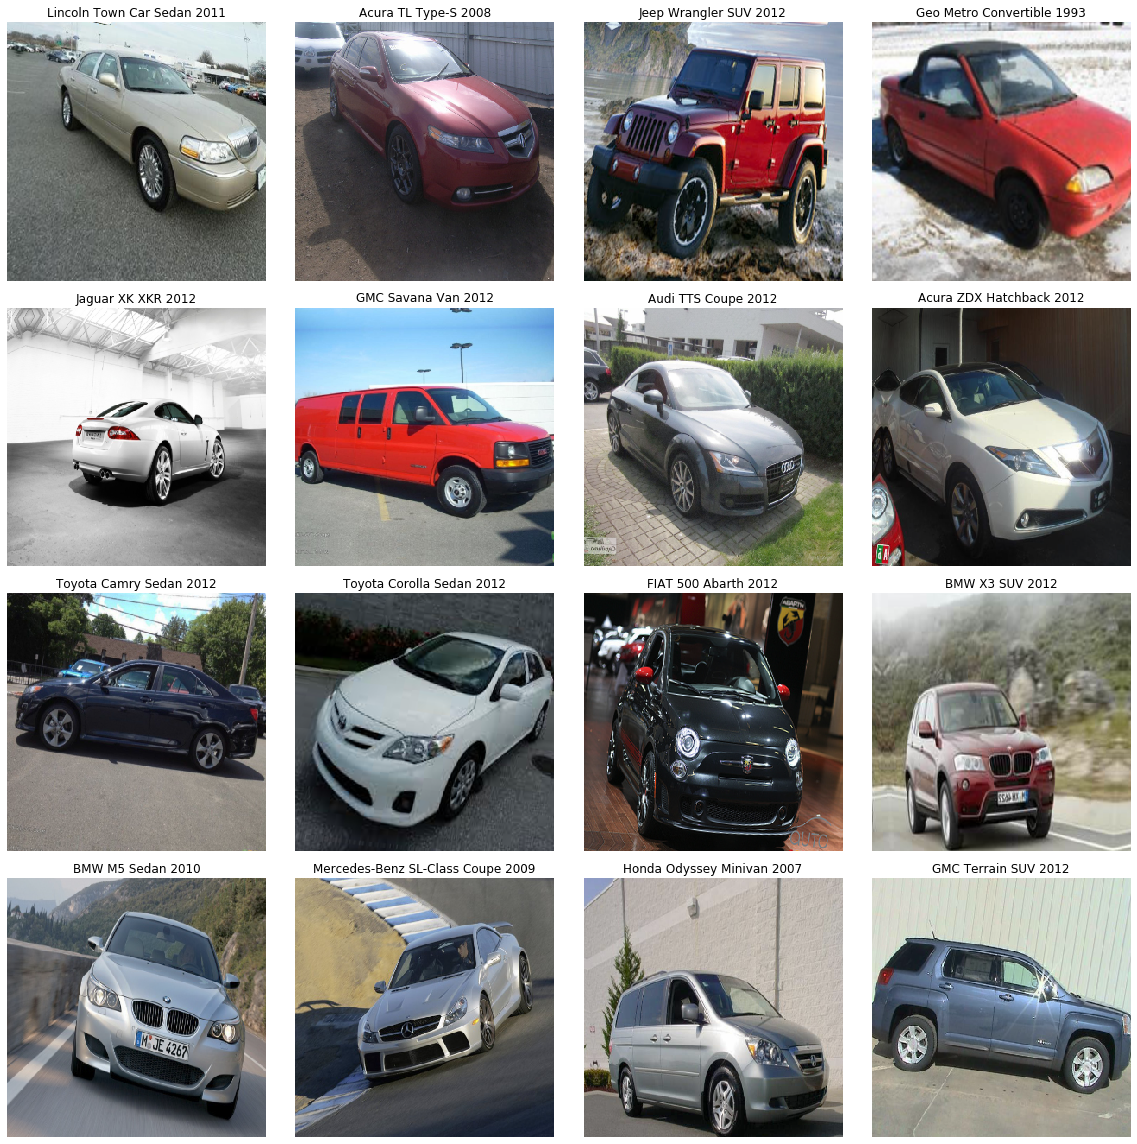

In [9]:
# Show some transformed images of the train set
data.show_batch(rows=4, ds_type=DatasetType.Train)

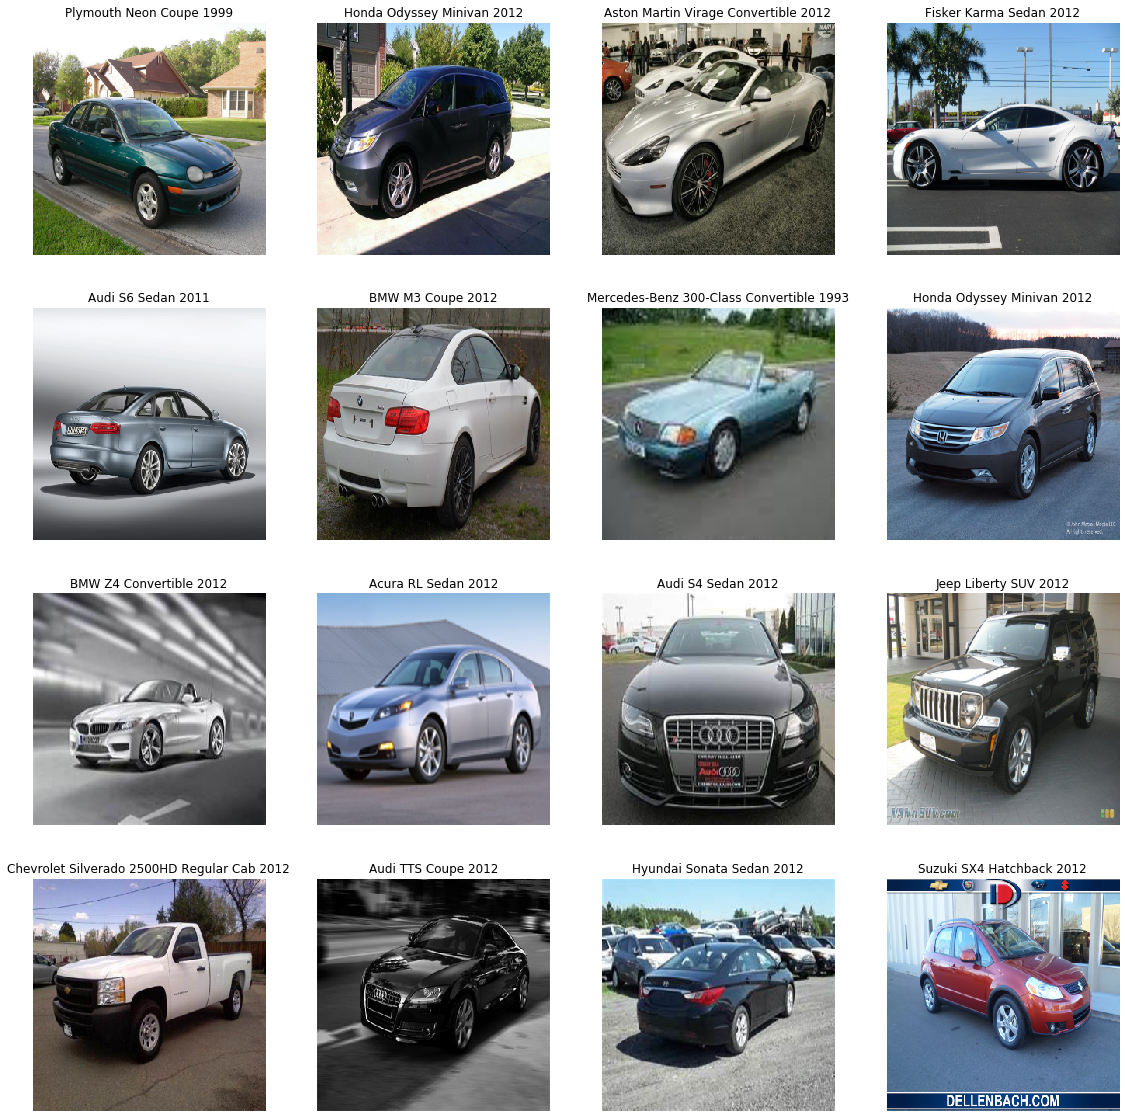

In [10]:
# Show some transformed images of the valid set
data.show_batch(rows=4, ds_type=DatasetType.Valid)

## 1.2 Getting Learner

`Learner` is an object in fastai to train a `model` using `data` to minimize `loss_func` with optimizer `opt_func`. To create a CNN learner, `cnn_learner` function can be used, which supports most of the pretrained models from [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html). It automatically replace the old head (the layers after the last conv layer) with a new head with correct number of outputs (inferred from `data`). See [vision.learner docs](https://docs.fast.ai/vision.learner.html#cnn_learner) for more info.

A few things to note:
- if `pretrained=True`, the model is freezed up to the head.
- the default `opt_func` is Adam. If `true_wd=True` which is the default, it uses methods from [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101) to fix the weight decay regularization in Adam (L2 and weight decay regularization are equivalent for SGD, but not for Adam).
- Modern techniques which improves model performance like label smoothing and mixup can be easily utilized thanks to fastai. See code below.

In [11]:
# Create a Learner with pretrained Resnet-50
learn = cnn_learner(data, 
                    models.resnet50, 
                    pretrained=True,
                    true_wd=True,
                    loss_func=LabelSmoothingCrossEntropy(),    # Use label smoothing
                    metrics=[accuracy], 
                    path='.', callback_fns=ShowGraph)
learn = learn.mixup(alpha=0.3)    # Use mixup

In [12]:
# Check the head after the last conv layer
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=196, bias=True)
)

In [13]:
# Use mixed precision training
learn = learn.to_fp16()

In fastai, `lr_find` method can be used to estimate the optimal maximum learning rate. Generally, learning rate where the gradient d_loss/d_lr is the steepest can be used in the beginning before any hyperparameter optimization.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


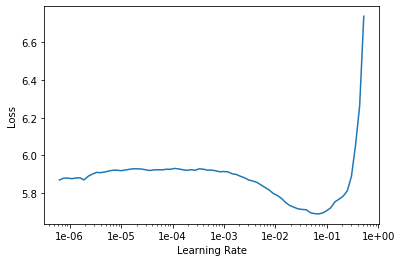

In [14]:
learn.lr_find()
learn.recorder.plot()

After a suitable learning rate is found, training using `fit_one_cycle` method to train with 1cycle policy. The training starts with a learning rate warm up from `max_lr/div_factor` up to `max_lr`, followed by cosine annealing to a final learning of `max_lr/final_div`. The length of warm up can be specified with `pct_start`.

`max_lr` is the main hyperparameter to be specified. The defaults of `div_factor`, `final_div` and `pct_start` are suitable in most cases. Besides learning rate, the momentum is also changed at each iteration. See the plot below for visualization of the learning rates and momentums during training with 1cycle policy.

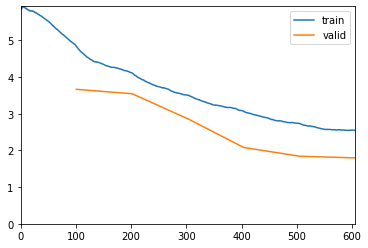

In [15]:
# For demo purpose, I just use 6 epochs here
epochs = 6
lr = 1e-2
wd = 1e-3
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd, div_factor=25, pct_start=0.3)  # div_factor and pct_start are defaults

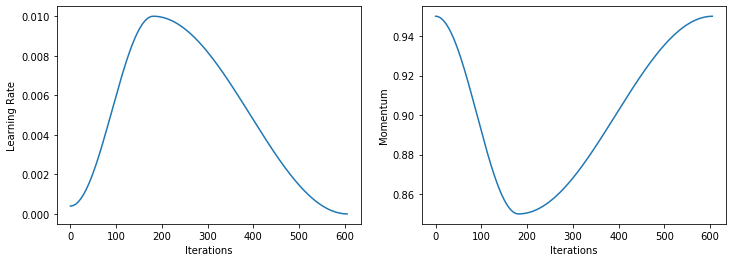

In [16]:
# Visualize the learning rates and momemtums during training with 1cycle policy
learn.recorder.plot_lr(show_moms=True)

In this section, I have introduced the key features of fastai library which I use in my experiments for this challenge. For more information please checkout the [documention](https://docs.fast.ai/index.html) or search in [fastai forum](https://forums.fast.ai/).

# 2. Final Solution - Best Training Pipeline for Efficientnet-B0 and Resnet-50
I choose Efficientnet-B0 ([Tan & Le, 2019](https://arxiv.org/abs/1905.11946)) as my final solution and Resnet-50 as the baseline. Both are fine-tuned from the Imagenet pretrained weights. **92+ % test accuracy** was achieved with just **60 epochs** at a batch size of 32 or 64 for both models. In comparison, Tan & Le, 2019 used training settings from [Kornblith et al. 2018](https://arxiv.org/abs/1805.08974) for fine-tuning pretrained Efficientnet-B0 with 20,000 steps at a batch size of 256 to reach ~90.8% test accuracy (they used image size of 224x224, I used 300x300).

The results of the Efficientnet-B0 and the Resnet-50 are compared in the table below, which are evaluated in the next two sections [3. Evaluation of Final Solution](#3.-Evaluation-of-Final-Solution) and [4. Evaluation of Inference Time](#4.-Evaluation-of-Inference-Time) . While the average test accuracy is slightly lower than the Resnet-50, Efficientnet has significantly lower number of parameters (**8.9MB exported**) and **faster inference on CPU**.

*Table 1: Comparison of EfficientBet-B0 and ResNet-50 for Stanford Car Dataset. Test accuracy and training time are averaged over 8 runs. Batch size of 1 is used to measure the CPU inference time. Training time and CPU inference time are based on a machine with Intel Core i5-8600K and Nvidia GeForce RTX 2070.*

| Model                   | #Params   | Training Time / Epoch | CPU Inference Time / Image| Test Accuracy  |
| ---                     | :---:     | :---:                 |:---:                      | ---:           |
| EfficientNet-B0 (my)    | 4.3M      | 57.4 s                | 0.11454 s                 | 92.43%         |
| ResNet-50 (my)          | 25.7M     | 51.9 s                | 0.18057 s                 | **92.64%**     |
| EfficientNet-B0 (Tan & Le 2019)   | 5.3M* |   -             |       -                   |90.8%**         |

_\* 5.3M is the #Params for ImageNet. Tan & Le, 2019 did not report the #Params for Stanford Car dataset._  
_\*\* Image size for EfficientNet-B0 is 224x224 in Tan & Le, 2019, 300x300 in my solution._


On the other side, there are also some downsides of Efficientnet:
- it is slower to be trained (higher training time/epoch) despite of having much less parameters than Resnet-50. Based on some research on internet (e.g. [this blog post](https://mc.ai/does-efficientnets-improve-cnn-scaling/) and [this issue](https://github.com/lukemelas/EfficientNet-PyTorch/issues/10)), it seems like it is due to the depthwise convolutions (main operation in EfficientNet and other similar light weight models like MobileNet) are slower than regular convolutions.
- it consumes more memory to train/infer than Resnet-50. On my system (RTX 2070), Efficientnet-B0 can be train only with a maximum batch size of 32 (chosen from 16,32,64,128...), while Resnet-50 can be trained with up to a batch size of 64. This becomes an disadvantage to be used in low memory devices.

The best training pipelines are shown in the next two subsections:
- [2.1 Efficientnet-B0](#2.1-Efficientnet-B0) and
- [2.2 Resnet-50](#2.2-Resnet-50).

**Summary of what I did:**  
I set my goal to train a light weight and fast model which is suitable for mobile devices. I wanted to try MobileNet, but I discovered the latest EfficientNet from tweets which looked very promising. Therefore, throughout this challenge, I mainly experimented with Resnet-50 (as baseline), Efficientnet-B0 and Efficientnet-B3 using different data augmentations and some tricks from [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187), which are implemented in fastai. I did a little experiments to optimize the hyperparameters and I only did 1 run for each experiment with fixed seed to split the validation set, due to limited time and computing resource.

Methods that showed significant improvement in accuracy are:
- the extra transformations of zoom_crop with larger scale range and cutout
- Label smoothing and mixup

Finally, I choose Efficientnet-B0 as my final solution because the highest accuracy of Efficientnet-B3 was found to be similar to Efficientnet-B0 if the image size is (300, 300). 

## 2.1 Efficientnet-B0
Key options and hyperparameters:
- extra transforms for data augmentation: 
  - zoom_crop(scale=(0.75,1.5), do_rand=True) 
  - cutout(n_holes=(1,4), length=(10, 40), p=0.7))
- image size: (300,300)
- LabelSmoothingCrossEntropy()
- mixup(alpha=0.3)
- bs = 32
- max_lr = 3e-3
- wd = 1e-3
- epoch = 60

> Note: this section can be ran independently after importing the first cell.

In [3]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [4]:
xtra_tfms = zoom_crop(scale=(0.75,1.5), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 40), p=0.7)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data = get_car_data(dataset="train", tfms=tfms, bs=32, sz=(300, 300), 
                                     padding_mode="reflection", stratify=True, seed=42)

In [5]:
eff_net = get_effnet(name="efficientnet-b0", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.3)
learn = learn.to_fp16()

Getting pretrained efficientnet-b0
Loaded pretrained weights for efficientnet-b0


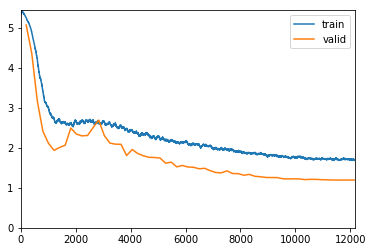

In [6]:
lr = 3e-3
wd = 1e-3
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd, div_factor=25, final_div=1e4)

In [7]:
learn.save("effnet-B0")

## 2.2 Resnet-50
Resnet-50 is trained in two phases. Phase 1 trains only the head for 20 epochs. Phase 2 unfreezes the whole model and trains all the weights for 40 epochs. Phase 2 also uses [discriminative layer training](https://docs.fast.ai/basic_train.html#Discriminative-layer-training) by using the `max_lr=slice(lr/10, lr)` option.

Key options and hyperparameters:
- extra transforms for data augmentation: 
  - zoom_crop(scale=(0.75,1.5), do_rand=True) 
  - cutout(n_holes=(1,4), length=(10, 40), p=0.5))
- image size: (300,300)
- LabelSmoothingCrossEntropy()
- mixup(alpha=0.3)
- bs = 64
- max_lr = 1e-2 for Phase 1, 3e-3 for Phase 2
- wd = 1e-5
- epoch = 60

> Note: this section can be ran independently after importing the first cell.

In [13]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [14]:
xtra_tfms = zoom_crop(scale=(0.75,1.5), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 40), p=0.5)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data = get_car_data(dataset="train", tfms=tfms, bs=64, sz=(300, 300), 
                                     padding_mode="reflection", stratify=True, seed=42)

In [15]:
learn = cnn_learner(train_val_data, models.resnet50, metrics=[accuracy], 
                    loss_func=LabelSmoothingCrossEntropy(), path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn = learn.to_fp16()

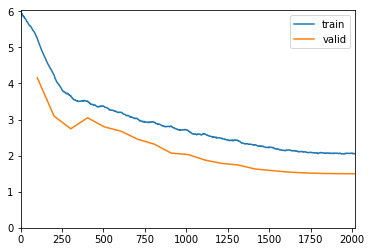

In [16]:
lr = 1e-2
wd = 1e-5
learn.fit_one_cycle(20, max_lr=lr, wd=wd, div_factor=25, pct_start=0.3)

In [17]:
learn.unfreeze()

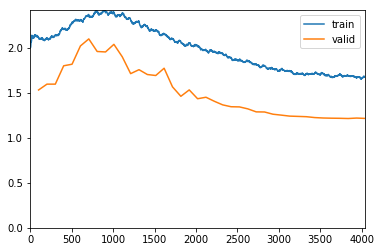

In [18]:
lr = 3e-3
wd = 1e-5
learn.fit_one_cycle(40, max_lr=slice(lr/10, lr), wd=wd, div_factor=25, pct_start=0.3)

In [19]:
learn.save("resnet50")

# 3. Evaluation of Final Solution

`train.py` are written using the training pipelines in the previous section to simplify evaluation and for submission. Refer to the README.md in this repository for usage explaination.

## 3.1 Retrain Efficientnet-B0 for 8 Runs

Efficientnet-B0 is retrained for 8 runs and the average metrics and training time are reported at the end.
- average validation accuracy = 92.7%
- average test accuracy = 92.43%
- average training time = 3443.97 s or 57.4 s per epoch

In [1]:
!python train.py -m efficientnet-b0 -n 8

Your selected model is efficientnet-b0, performing 8 training runs...

Training Run #1
Getting pretrained efficientnet-b0
Loaded pretrained weights for efficientnet-b0

Training efficientnet-b0 for 60 epochs...
epoch     train_loss  valid_loss  accuracy  time    
0         5.268177    5.116731    0.039288  00:57                       
1         4.915954    4.415504    0.143033  00:56                       
2         4.229703    3.269360    0.356661  00:56                       
3         3.432420    2.637910    0.518723  00:56                       
4         3.008642    2.198227    0.622468  00:56                       
5         2.746657    2.046867    0.667281  00:57                       
6         2.668028    2.072784    0.659300  00:56                       
7         2.638936    2.182145    0.630448  00:56                       
8         2.633600    2.041384    0.671578  00:56                       
9         2.643142    2.263003    0.622468  00:56                        
10   

17        2.533544    1.992215    0.695519  00:57                        
18        2.469840    2.224349    0.639042  00:57                        
19        2.452491    1.956835    0.711479  00:57                        
20        2.381664    1.821935    0.753223  00:57                        
21        2.397165    1.725886    0.771025  00:57                        
22        2.363050    1.766799    0.758134  00:56                        
23        2.285381    1.769496    0.764273  00:57                        
24        2.232884    1.703659    0.790669  00:56                        
25        2.240471    1.559952    0.820135  00:56                        
26        2.206348    1.564309    0.814610  00:57                        
27        2.207041    1.613656    0.811541  00:57                        
28        2.173236    1.492486    0.836710  00:56                        
29        2.084378    1.454648    0.848373  00:57                        
30        2.081636    1.431873    0.86

39        1.900910    1.340395    0.883364  00:57                        
40        1.872844    1.331427    0.887047  00:56                        
41        1.859460    1.276339    0.907305  00:57                        
42        1.834207    1.299485    0.885819  00:57                        
43        1.794828    1.242867    0.906077  00:57                        
44        1.813270    1.239257    0.911602  00:57                        
45        1.806447    1.233340    0.913444  00:56                        
46        1.771976    1.235560    0.918355  00:57                        
47        1.773058    1.204521    0.919583  00:57                        
48        1.792466    1.198564    0.920196  00:57                        
49        1.765346    1.202032    0.925107  00:57                        
50        1.724195    1.201105    0.922652  00:57                        
51        1.733661    1.193558    0.923880  00:57                        
52        1.731397    1.190013    0.92

## 3.2 Retrain Resnet-50 for 8 Runs
Resnet-50 is retrained for 8 runs and the average metrics and training time are reported at the end.
- average validation accuracy = 92.93%
- average test accuracy = 92.64%
- average training time = 3113.14 s or 51.9 s per epoch

In [2]:
!python train.py -m resnet-50 -n 8

Your selected model is resnet-50, performing 8 training runs...

Training Run #1

Training resnet-50 for 20 + 40 epochs...
Phase 1, training head...
epoch     train_loss  valid_loss  accuracy  time    
0         5.193850    4.198626    0.167587  00:50                       
1         4.265569    3.125562    0.373849  00:45                       
2         3.615352    2.813791    0.439533  00:46                       
3         3.482910    2.861683    0.445058  00:46                       
4         3.362022    2.989501    0.411909  00:46                       
5         3.208197    2.709125    0.457950  00:46                       
6         3.003619    2.483636    0.538981  00:46                       
7         2.909260    2.356485    0.580110  00:49                       
8         2.806090    2.110572    0.674647  00:48                       
9         2.702239    2.044848    0.689380  00:45                        
10        2.572448    1.855159    0.739104  00:46                  

16        2.106716    1.514717    0.861265  00:46                        
17        2.065160    1.496420    0.868017  00:46                        
18        2.065627    1.492430    0.866789  00:46                        
19        2.031055    1.490399    0.873542  00:45                        
Phase 2, unfreezed and training the whole model...
epoch     train_loss  valid_loss  accuracy  time    
0         2.057592    1.519579    0.851443  00:53                       
1         2.080024    1.590073    0.836710  00:53                       
2         2.108657    1.675744    0.802333  00:54                       
3         2.204879    1.830408    0.731737  00:53                       
4         2.281317    1.803396    0.767342  00:54                       
5         2.330097    1.951028    0.710866  00:54                       
6         2.399173    2.037170    0.696133  00:54                       
7         2.382191    2.130154    0.658072  00:54                       
8         2.4148

15        2.146649    1.627684    0.815224  00:55                        
16        2.129266    1.508473    0.847759  00:54                        
17        2.087738    1.495953    0.858195  00:54                        
18        2.048853    1.513900    0.846532  00:54                        
19        1.999342    1.471973    0.864948  00:54                        
20        1.992090    1.440960    0.866176  00:54                        
21        1.947334    1.436450    0.865562  00:55                        
22        1.916774    1.393335    0.886433  00:55                        
23        1.910558    1.374868    0.893800  00:54                        
24        1.872693    1.332577    0.909761  00:54                        
25        1.856053    1.331566    0.901780  00:54                        
26        1.814924    1.306251    0.907919  00:55                        
27        1.775279    1.282669    0.907919  00:55                        
28        1.776416    1.267000    0.92

# 4. Evaluation of Inference Time

## 4.1 CPU Inference Time of Efficientnet-B0

Test CPU inference time with batch size of 1

In [3]:
!python test.py -m best_efficientnet-b0.pkl -d cpu -bs 1

Path to test images folder	: Data/cars_test/
Number of test images		: 8041
Loaded inference model		: exported_models/best_efficientnet-b0.pkl
Inference device		: cpu
Batch size			: 1


Calculating accuracy of the test set...
Accuracy on the test set: 92.70%                       
Total inference time: 15 mins 21 s 


In [2]:
time_per_im = (15 * 60 + 21) / 8041
print(f"CPU inferece time per image is {time_per_im:.05f} s")

CPU inferece time per image is 0.11454 s


## 4.2 CPU Inference Time of Resnet-50

Test CPU inference time with batch size of 1

In [4]:
!python test.py -m best_resnet-50.pkl -d cpu -bs 1

Path to test images folder	: Data/cars_test/
Number of test images		: 8041
Loaded inference model		: exported_models/best_resnet-50.pkl
Inference device		: cpu
Batch size			: 1


Calculating accuracy of the test set...
Accuracy on the test set: 92.79%                       
Total inference time: 24 mins 12 s 


In [3]:
time_per_im = (24 * 60 + 12) / 8041
print(f"CPU inferece time per image is {time_per_im:.05f} s")

CPU inferece time per image is 0.18057 s


# fin